In [1]:
import pickle 
import pandas as pd 

import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
import scikitplot as skplt
from helpers.pipeline_ops import sk_model_stats
from sklearn.metrics import RocCurveDisplay

from data.get_data import source_data
from helpers.eda import topn_tfidf_freq, tfidf_visuals

In [2]:
data_url = 'https://files.consumerfinance.gov/ccdb/complaints.csv.zip'
project_folder = 'C:\\Users\\zjc10\\Desktop\\Projects\\code\\qas4_casestudy'
text_colname = 'text'
target = 'product_group'

In [6]:
#raw df 
raw_df = source_data(data_url, project_folder)
raw_df = raw_df.rename(columns={'text':'orig_text'})

#preprocessed df 
with open(project_folder+'\\data\\cfpb_postbowfilter.pickle', "rb") as input_file:
        processed_df = pickle.load(input_file)
        
#add string to labelid
df = pd.merge(processed_df, raw_df[['complaint_id','product_group']]
                        ,how='left',left_on='complaintid', right_on='complaint_id')#.drop('complaintid')


#ref map for id to string levels
y_dic = {}
for idx, row in df[['labelid','product_group']].drop_duplicates().iterrows():
    y_dic[row['labelid']] = row['product_group']

### Plot distribution of target and total words in text to be used in modeling 
#### Finding 
   - **Class imbalance exists** -> Oversampling will be used to mitigate rare class level for money_transfers
       - **Alternate Solution**: Collapse target levels based on levels that have similar distribution of WORDS in text

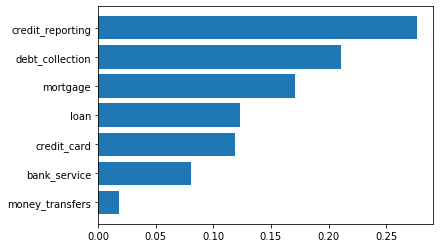

              index  product_group
0  credit_reporting       0.276741
1   debt_collection       0.210651
2          mortgage       0.170836
3              loan       0.123025
4       credit_card       0.119080
5      bank_service       0.081082
6   money_transfers       0.018585


,count,mean,std,min,25%,50%,75%,max
product_group,,,,,,,,
bank_service,17756.0,86.622944,72.212296,14.0,40.0,65.0,110.0,1211.0
credit_card,26077.0,82.662576,69.674768,15.0,39.0,63.0,103.0,1950.0
credit_reporting,60603.0,65.944260,60.572586,6.0,32.0,48.0,78.0,1628.0
debt_collection,46130.0,66.615391,61.782288,13.0,31.0,48.0,80.0,1953.0
loan,26941.0,82.576927,73.271379,15.0,38.0,61.0,103.0,2048.0
money_transfers,4070.0,82.091155,81.225259,18.0,37.0,60.0,98.0,1910.0
mortgage,37411.0,103.354094,93.244061,15.0,46.0,77.0,134.0,2758.0


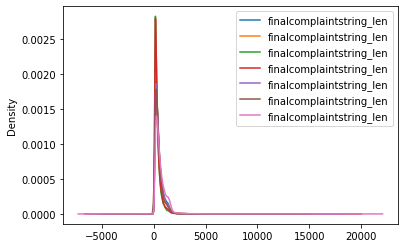

In [4]:
from helpers.eda import run_eda 
run_eda(df, 'finalcomplaintstring','product_group')
p_tot = df[target].value_counts()/len(df)
print(p_tot.reset_index())

# view distribution of text by product group
df[f'{text_colname}_len'] = df[text_colname].apply(lambda x: len(x))
df.groupby(target)[f'{text_colname}_len'].describe()

#### Get top TFIDF Weighted terms per cluster 

In [7]:
tf_top_terms = {}
for lvl in df.product_group.unique():
    tf_top_terms[lvl] = topn_tfidf_freq(df[df['product_group']==lvl].sample(4000), 'finalcomplaintstring', n=20)
    
for idx,(k,v) in enumerate(tf_top_terms.items()):
    if idx==0:
        dff = pd.DataFrame(v).reset_index().head(20)
        dff['product'] = k
    else:
        dfff = pd.DataFrame(v).reset_index().head(20)
        dfff['product'] = k
        dff = pd.concat([dff,dfff])
dff.to_clipboard()

c:\users\zjc10\desktop\projects\envs\dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\users\zjc10\desktop\projects\envs\dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\users\zjc10\desktop\projects\envs\dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\users\zjc10\desktop\projects\envs\dev\lib\site-packages\sklearn\utils\deprecation.py:87:

### Evaluate / Explore unsupervised groupings in TFIDF matrix and visualize via Kmeans -> PCA -> TSNE

cluster done
pca done


c:\users\zjc10\desktop\projects\envs\dev\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


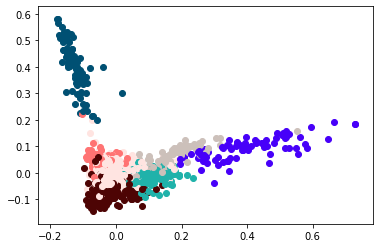

'plot complete'

In [38]:
from helpers.eda import get_tfidf_vectorizer
tfidf_in = df.groupby('product_group', group_keys=False).apply(lambda x: x.sample(500))
tfidf_v = get_tfidf_vectorizer(max_df=100, min_df = 2,max_features=1000)
tfidf_vec = tfidf_v.fit_transform(tfidf_in['finalcomplaintstring'])
tfidf_visuals(tfidf_vec,tsne=False)

### MODEL RESULT ANALYSIS 
#### NOTE: ALL MODELS ARE RUN FROM TERMINAL AND RESULTS SAVED AND OUTPUT FOR REVEIW

In [7]:
#save the results
project_folder = 'C:\\Users\\zjc10\\Desktop\\Projects\\code\\qas4_casestudy'

import pickle
with open(f'{project_folder}\\models\\model_fits_.pickle', 'rb') as handle:
    pipe_fit = pickle.load(handle)

with open(f'{project_folder}\\data\\model_ready_data_.pickle', 'rb') as handle:
    data_dic = pickle.load(handle)

with open(f'{project_folder}\\output\\model_metrics_.pickle', 'rb') as handle:
    model_metrics = pickle.load(handle)

with open(f'{project_folder}\\output\\cm_stats_.pickle', 'rb') as handle:
    cm_stats = pickle.load( handle)

with open(f'{project_folder}\\output\\preds_.pickle', 'rb') as handle:
    preds = pickle.load(handle)

with open(f'{project_folder}\\output\\feats_.pickle', 'rb') as handle:
    feats = pickle.load( handle)

In [12]:
import sklearn 
#classficiation report info 
report_out = []
for run in ['train','valid']:
    for k in pipe_fit.keys():
        runn = 'training' if run =='train' else 'validation'

        report = pd.DataFrame(sklearn.metrics.classification_report(data_dic[runn]['y']
                                              , preds[run][k]['preds']
                                             ,output_dict = True)

                    ).rename(columns={str(k):v for k,v in y_dic.items()})
        report['model'] = k
        report['run']=run
        report_out.append(report)
pd.concat(report_out).to_clipboard()#.pivot_table(index='model', columns=['run','accuracy']).T

In [14]:
x_test = data_dic['validation']['x']
y_test = data_dic['validation']['y']
x_train = data_dic['training']['x']
y_train = data_dic['training']['y']


mod ='pipe_gbm'
y_pred = preds['valid'][mod]['preds']

model = pipe_fit[mod]['clf']

C:\Users\zjc10\Desktop\Projects\envs\dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


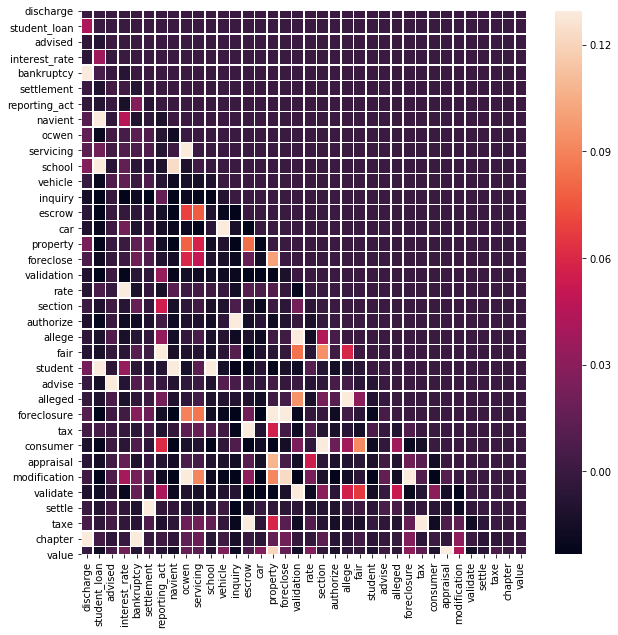

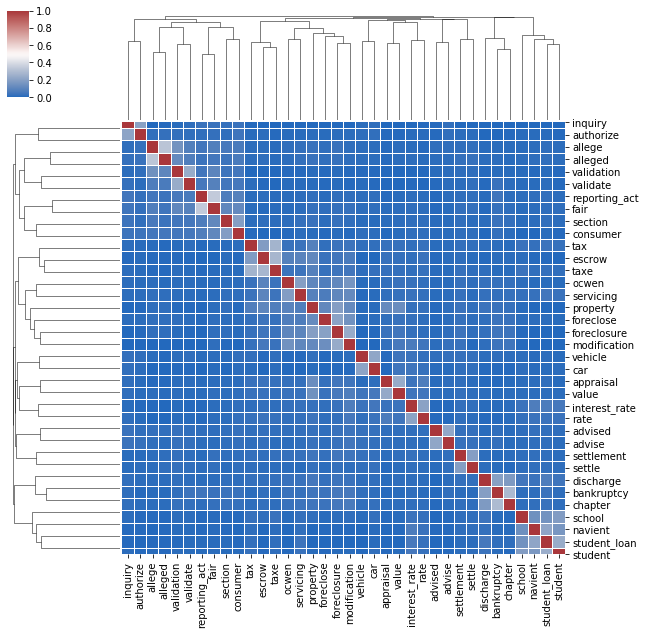

In [16]:
import seaborn as sns
#fit orig pipe to input 
feats_fit = feats.fit_transform(x_train)

#extract feature names from each pipeline to map to output df used for prelim statistical analysis  
feat_names = feats.transformer_list[0][1].named_steps['tfidf'].get_feature_names()

#creat df to conduct preliminary analysis on 
feat_df=pd.DataFrame(feats_fit.todense())
feat_df.columns = feat_names
feat_df['product']= [y_dic[x] for x in y_train]

#generate corrlation matrix of input features 
corr_df = feat_df[[v for v in list(feat_df) if v !='product']].corr(min_periods=3)#feat_df[numcols].rename_axis(None).rename_axis(None, axis=1)
mask = np.triu(np.ones_like(corr_df, dtype=np.bool), k=-1)
unique_corr_df = corr_df.where(mask) #upper triangle of corr matrix 
cor_df = unique_corr_df.unstack().reset_index();cor_df.columns = ['var1','var2','corr'];cor_df.dropna(inplace=True) #converting matrix to long format 

#subset corrolations 
cor_subset = cor_df[(cor_df['corr']>.17)&(cor_df['corr']<.9)] #filtering vairable corrolations out based on relationship magnitude
#cor_sub_mat = cor_subset.pivot('var1','var2','corr').fillna(0)
topCorVars = list(set(list(cor_subset.var1.unique())+list(cor_subset.var2.unique())))
topCor_DF = feat_df[topCorVars]
topCor_df = topCor_DF.corr()
mask = np.tril(np.ones_like(topCor_df, dtype=np.bool), k=-1)
topCorr_df = topCor_df.where(mask).fillna(0)

#correlation map of top corrolations 
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(topCorr_df, annot=False, linewidths=.5, fmt= '.01f',ax=ax,robust=True,cbar=True)
#sns.heatmap(topCorr_df, annot=False,ax=ax,robust=True,cbar=True)

#cluster mapping of corrolations 
sns.clustermap(topCor_df
               ,row_cluster=True
               ,col_cluster=True
               ,linewidths=.01
               ,fmt='.01f'
               ,figsize=(10,10)
               #,mask = np.triu(np.ones_like(topCorr_df, dtype=np.bool), k=0)
               ,standard_scale=1
               ,cmap="vlag"
               
              )


### DETAILED BOW PERFORMANCE REVIEW

Model Validation Charts pipe_log:


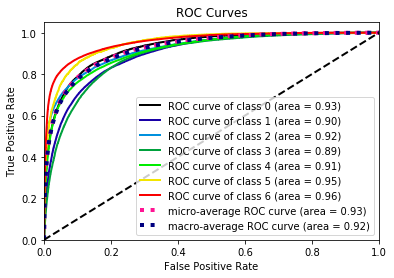

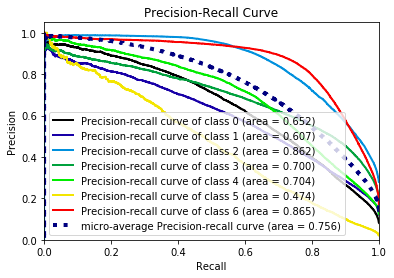

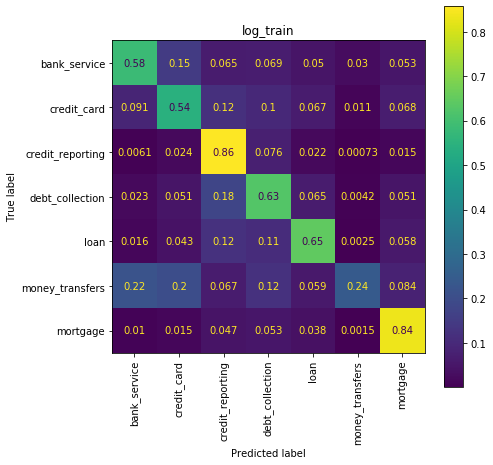

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.7s finished


Model Validation Charts pipe_rf:


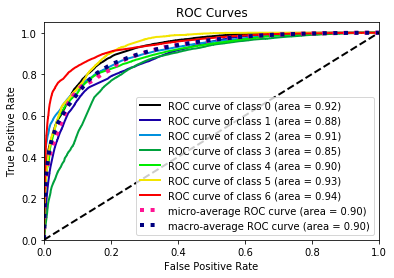

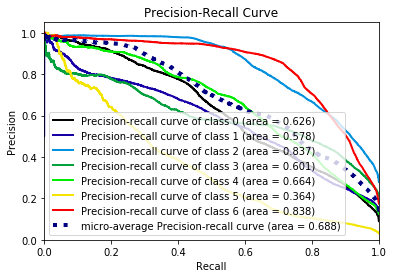

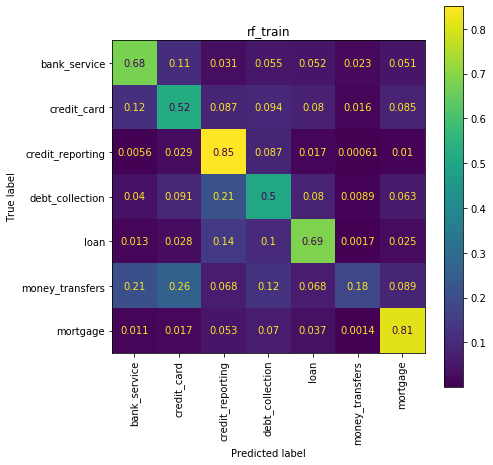

Model Validation Charts pipe_gbm:


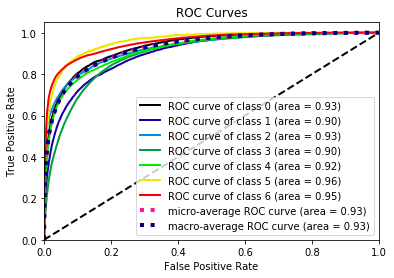

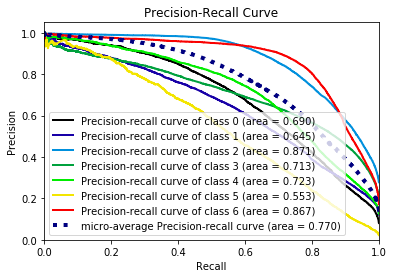

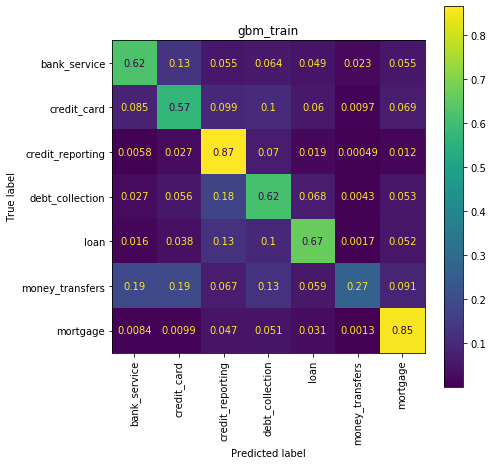

Model Validation Charts pipe_log:


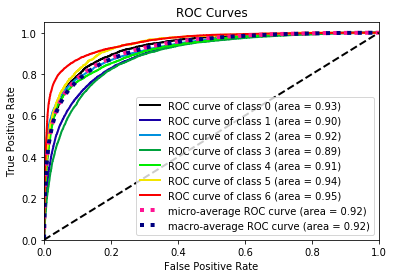

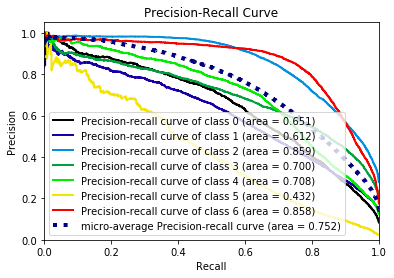

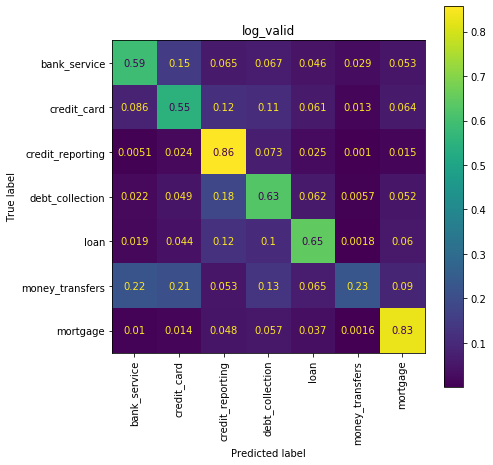

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


Model Validation Charts pipe_rf:


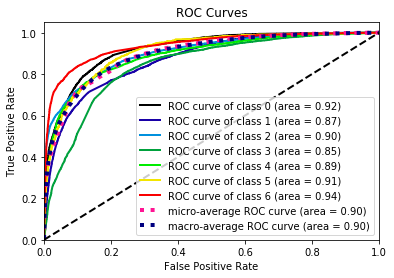

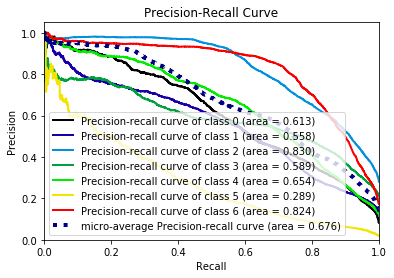

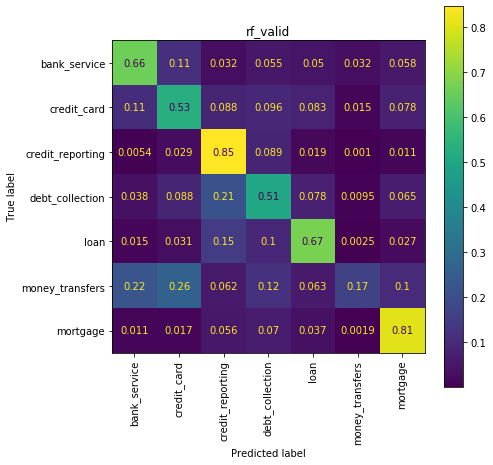

Model Validation Charts pipe_gbm:


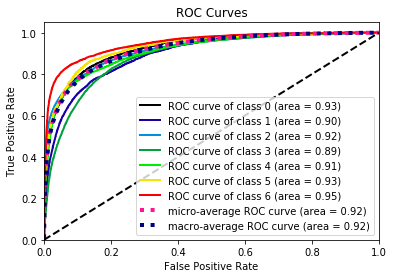

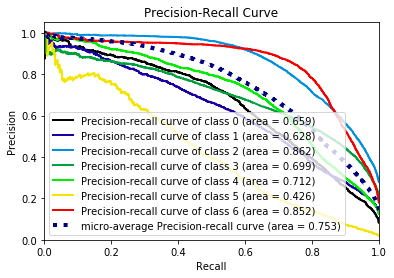

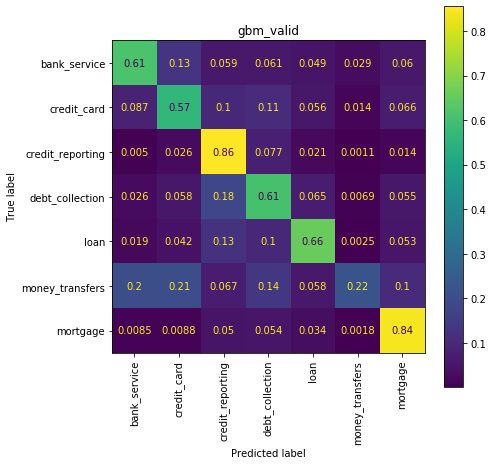

In [20]:
from helpers.pipeline_ops import sk_model_stats
from sklearn.metrics import RocCurveDisplay
import sklearn
report_out = []
for run in ['train','valid']:
    for k in pipe_fit.keys()  :

            runn = 'training' if run =='train' else 'validation'

            report = pd.DataFrame(sklearn.metrics.classification_report(data_dic[runn]['y']
                                                  , preds[run][k]['preds']
                                                 ,output_dict = True)

                        ).rename(columns={str(k):v for k,v in y_dic.items()})

            report['model'] = k
            report['run']=run
            report_out.append(report)

            out, cm_stats, preds_out = sk_model_stats({k:pipe_fit[k]}
                           , data_dic[runn]['x']
                           , data_dic[runn]['y']
                           , data_type=run
                           , plot=True)

            fig, ax = plt.subplots(figsize=(7,7))
            cmp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions( [y_dic[x] for x in preds[run][k]['preds']] #preds['train']['pipe_gbm']['preds']
                                                    ,[y_dic[x] for x in data_dic[runn]['y']]
                                                    , normalize='true'
                                                    , labels = [v for k,v in y_dic.items()]
                                                    , xticks_rotation='vertical'
                                                    , values_format = '.2'
                                                    , ax=ax
                                                   )


            #cmp.plot(ax=ax)
            plt.title(f"{k.replace('pipe_','')}_{run}")
            plt.show()


#save copy of report to clip and put in excel 
pd.concat(report_out).to_clipboard()

### Logistic Feature Importance

Text(0.5, 1.0, 'logistic feature importance')

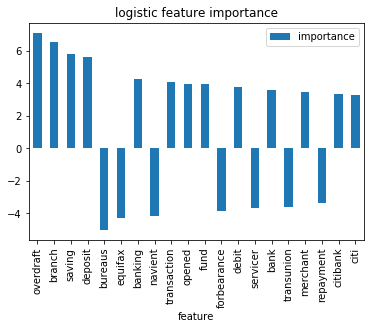

In [616]:
from matplotlib import pyplot

mod = 'pipe_log'
support = pipe_fit[mod].named_steps['feature_selection'].get_support()
feat_names = pipe_fit[mod]['features'].transformer_list[0][1].named_steps['tfidf'].get_feature_names()
fnames = np.array(feature_names)[support]

imptance = pipe_fit[mod]['clf'].coef_[0]

feat_imps = pd.DataFrame([tup for tup in zip(fnames, imptance)])
feat_imps.columns =['feature','importance']
feat_imps['sort'] = abs(feat_imps['importance'])
feat_imps=feat_imps.sort_values(by='sort',ascending=False)
feats_plot = feat_imps.head(20)
feats_plot.plot(x='feature', y='importance',kind='bar')
plt.title('logistic feature importance')



### GBM FEATURE IMPORTANCE 

Text(0.5, 1.0, 'gbm feature importance')

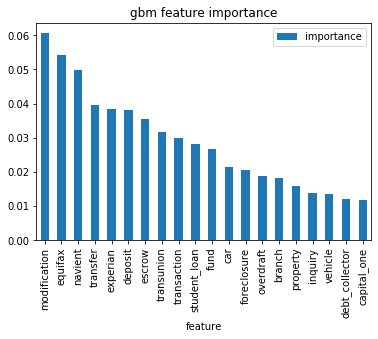

In [614]:
mod = 'pipe_gbm'
support = pipe_fit[mod].named_steps['feature_selection'].get_support()
feature_names = pipe_fit[mod]['features'].transformer_list[0][1].named_steps['tfidf'].get_feature_names()
fnames = np.array(feature_names)[support]


feat_imps = pd.DataFrame([tup for tup in zip(fnames, pipe_fit[mod]['clf'].feature_importances_)])
feat_imps.columns =['feature','importance']
feat_imps=feat_imps.sort_values(by='importance',ascending=False)
feat_imps.head(20).plot(x='feature',y='importance',kind='bar')
plt.title('gbm feature importance')

### CHAMPION MODEL HYPER PARAM AND CV GBM OVERVIEW

In [24]:
#save the results
project_folder = 'C:\\Users\\zjc10\\Desktop\\Projects\\code\\qas4_casestudy'

import pickle

#HYPER PARAM 
with open(f'{project_folder}\\data\\cv_metrics.pickle', 'rb') as handle:
    cv_metrics = pickle.load(handle)

with open(f'{project_folder}\\data\\data_dic_gbm.pickle', 'rb') as handle:
    data_dic_gbm = pickle.load(handle)
    
with open(f'{project_folder}\\output\\gbm_val_preds.pickle', 'rb') as handle:
    gbm_preds = pickle.load(handle)
    
with open(f'{project_folder}\\output\\gbm_cm.pickle', 'rb') as handle:
    gbm_cm = pickle.load(handle)

    
#FINAL GBM 
with open(f'{project_folder}\\data\\hp_clf.pickle', 'rb') as handle:
    hp_clf = pickle.load(handle)

with open(f'{project_folder}\\output\\final_gbm_probs.pickle', 'rb') as handle:
    gbm_probs = pickle.load(handle)




UnpicklingError: invalid load key, 'v'.

Model Validation Charts gbm_champ:


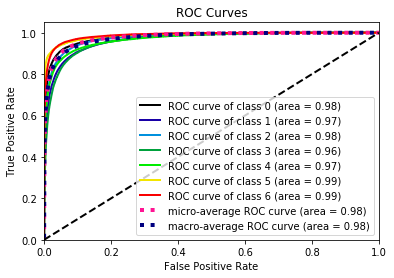

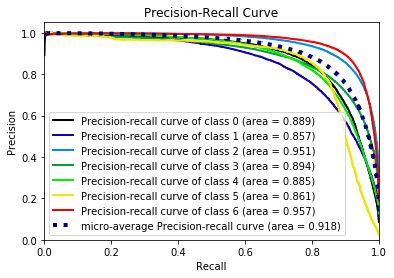

In [678]:
#CHAMPTION MODEL METRICS ON FULLLL DATA 
champ_stats = sk_model_stats({'gbm_champ':hp_clf}
                           , pd.concat([data_dic_gbm['training']['x'],data_dic_gbm['validation']['x']])
                           , pd.concat([data_dic_gbm['training']['y'],data_dic_gbm['validation']['y']])
                           , data_type='train'
                           , plot=True)

In [647]:
train_preds = hp_clf.predict(data_dic_gbm['training']['x'])
test_preds = hp_clf.predict(data_dic_gbm['validation']['x'])

cf_val = metrics.confusion_matrix(data_dic_gbm['validation']['y'], test_preds)
cf_train = metrics.confusion_matrix(data_dic_gbm['training']['y'], train_preds)

In [683]:
gbm_val_ctm = pd.DataFrame(cf_val).rename(columns=y_dic)
gbm_val_ctm.index= [y_dic[v] for v in gbm_val_ctm.index.values]
gbm_val_ctm

gbm_train_ctm = pd.DataFrame(cf_train).rename(columns=y_dic)
gbm_train_ctm.index= [y_dic[v] for v in gbm_train_ctm.index.values]
gbm_train_ctm

,bank_service,credit_card,credit_reporting,debt_collection,loan,money_transfers,mortgage
bank_service,12000,700,384,679,180,35,227
credit_card,538,16893,1158,1622,354,58,238
credit_reporting,190,881,43327,2729,709,24,622
debt_collection,210,773,2232,31954,1015,23,697
loan,261,588,953,1782,17434,20,515
money_transfers,76,84,35,107,14,2909,31
mortgage,215,526,599,1015,260,18,27296



### SEQ MODEL RESULTS 


In [306]:
lstm_ctm = pd.DataFrame(lstm_cm).rename(columns=y_dic)
lstm_ctm.index= [y_dic[v] for v in lstm_ctm.index.values]
lstm_ctm

,bank_service,credit_card,credit_reporting,debt_collection,loan,money_transfers,mortgage
bank_service,606,80,12,32,20,38,12
credit_card,75,624,24,45,18,14,0
credit_reporting,16,46,570,110,44,1,13
debt_collection,19,34,56,612,58,4,17
loan,30,42,37,67,602,6,16
money_transfers,113,44,3,10,6,623,1
mortgage,43,14,26,26,25,6,660


In [617]:
with open(f'{project_folder}\\data\\xtr_lstm.pickle', 'rb') as handle:
    xtr = pickle.load(handle)
    
with open(f'{project_folder}\\data\\ytr_lstm.pickle', 'rb') as handle:
    ytr = pickle.load(handle)
    
with open(f'{project_folder}\\data\\xtest_lstm.pickle', 'rb') as handle:
    xtst = pickle.load(handle)
    
with open(f'{project_folder}\\data\\ytest_lstm.pickle', 'rb') as handle:
    ytst = pickle.load(handle)

with open(f'{project_folder}\\output\\cm_lstm_matrix.pickle', 'rb') as handle:
    lstm_cm  = pickle.load(handle)
    
with open(f'{project_folder}\\output\\lstm_scores.pickle', 'rb') as handle:
    lstm_scores = pickle.load(handle)

with open(f'{project_folder}\\output\\lstm_preds.pickle', 'rb') as handle: #TEST PREDS
    lstm_preds = pickle.load(handle)


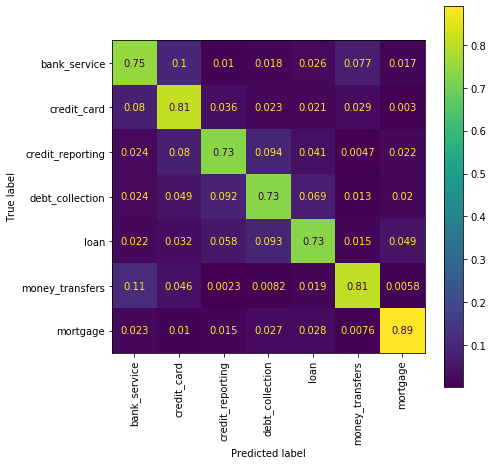

In [623]:
fig, ax = plt.subplots(figsize=(7,7))
cmp = ConfusionMatrixDisplay.from_predictions( [y_dic[x] for x in lstm_preds] #preds['train']['pipe_gbm']['preds']
                                        ,[y_dic[x] for x in ytst]
                                        , normalize='true'
                                        , labels = [v for k,v in y_dic.items()]
                                        , xticks_rotation='vertical'
                                        , values_format = '.2'
                                        , ax=ax
                                       )

In [624]:
from helpers.seq2seq_helpers import  load_best_model, recall, fmeasure, precision, fbeta_score

clf  = load_best_model('C:\\Users\\zjc10\\Desktop\\Projects\\code\\qas4_casestudy\\models\\best_bilstm.hdf5'
                            ,xtr=xtr
                            ,xte=xtst
                            ,ytr=ytr
                            ,yte=ytst
                           )

Final Model Confusion Matrix
[[2555  256   40   56   25  222   46]
 [ 188 2733   91   93   16   72    7]
 [  12  147 2475  395  101   10   60]
 [  18  104   99 2810   97   22   50]
 [  43  161   89  249 2578   24   56]
 [ 177   50    6   11    9 2927   20]
 [  28   12   41   69   50   15 2985]]
Final Model Confusion Matrix
[[590  72  17  16   9  84  12]
 [ 68 622  36  34   4  34   2]
 [  7  42 583 111  42   3  12]
 [  8  41  35 661  37   6  12]
 [ 15  56  34  81 580  12  22]
 [ 50  19   1  11   5 705   9]
 [  8  14  17  33  22   6 700]]
